In [1]:
import numpy as np
import scipy as sp
import cvxpy as cp
import pdb
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
'''
Declare the arrays that define the dynamical system as well
as the cost function for the optimization problem.

We have dynamics of the form x' = Ax + Bu (where the system is shifted for trajectory tracking)
and a quadratic cost function w/ step cost matrices Q,R and terminal cost P
'''
A = np.array([[1,1],[0,1]])
B = np.array([[0],[1]])

n,m = np.shape(B)
P = np.eye(n)
Q = np.eye(n)
R = 10*np.eye(m)

In [3]:
'''
Declare parameters and state matrices. Includes the prediction horizon over which MPC is solved
at every time step, the total time range to calculate on, state/control saturation limits, and
initial / final states.
'''
T = 3 # Prediction Horizon
T_tot = 10 # Total Time Horizon

xbar = 5 # State limit
ubar = .5 # Control limit
x_max = xbar; x_min = -xbar;
u_max = ubar; u_min = -ubar;

u_opt = np.zeros((m,T_tot))
X_opt = np.zeros((n,T_tot+1))
J_opt = 0


x0 = np.array([[-4.5],[2]])
x = x0
X_opt[:,[0]] = x0
xf = np.array([[0],[0]])

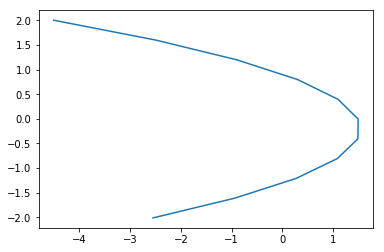

In [4]:
'''
Declare, solve, and visualize the optimization problem.
At every iteration of the total time range T_tot,
define a minimization problem of horizion T, solve it, and apply
the control action to yield the next state
'''

obj = 0.0
for i in range(0,T_tot):
    X = cp.Variable((n,T+1))
    U = cp.Variable((m,T))
    # pdb.set_trace()
    constraints = [   cp.max(X) <= x_max,
                      cp.min(X) >= x_min,
                      cp.max(U) <= u_max,
                      cp.min(U) >= u_min,
                      X[:,[0]] == x0,
#                      X[:,[-1]] == xf
                      X[:,1:] == cp.matmul(A,X[:,:-1])+cp.matmul(B,U)
                ]

    for j in range(T):
        obj += cp.atoms.quad_form(X[:,j], Q)
        obj += cp.atoms.quad_form(U[:,j], R)

    obj += cp.atoms.quad_form(X[:,T], Q)
  

    # pdb.set_trace()
    prob = cp.Problem(cp.Minimize(obj),constraints)
    result = prob.solve()

    if result == float('-inf') or result == float('inf'):
        print('problem Unbounded... ')
        J_opt = float('inf')
    else:
        u = U[:,[0]].value
        u_opt[:,i] = u
        x = np.matmul(A,x) + B*u
        X_opt[:,[i+1]] = x

np.set_printoptions(precision=2)

plt.figure()
plt.plot(X_opt[0,:],X_opt[1,:])
plt.show()
# pdb.set_trace()
# prob = generateProblem(A,B,P,Q);


In [6]:
J_opt

0